# Decision Tree

### Objective

This notebook introduces the decision tree models. Decision tree learning is one of the most widely used and practical methods for inductive inference. It's a method for approximating discreted-valued functions that is **robust** to **noisy data** and capable of **learning disjuctive** expressions.

### Learning objective

After finished this notebook, you should be able to explain **decision tree** learning models, as well as know to use them through the scikit-learn library


### Requirements

1. This notebook was created using
  * python 3.7.1
  * numpy 1.15.4
  * matplotlib 3.0.2
  * scikit-learn 0.20.1
  * seaborn 0.9.0
  * scipy 1.1.0

2. You can check your Python version by running
```python
import sys
print(sys.version)
```

3. and the version of any module by running
```python
import <module name>
print(<module name>.__version__)
```

## Loading the libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

We use `matplotlib` for data visualization together with its built-in interface called `pyplot`. Please check https://matplotlib.org/contents.html for more information.


### Decision trees in scikit-learn

In scikit-learn, decision trees are implemented through [tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for classification and [tree.DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for regression.

In [48]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## 1. Toy dataset

In order to better understand how a decision tree processes the feature space, let us first work on a simulated dataset. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


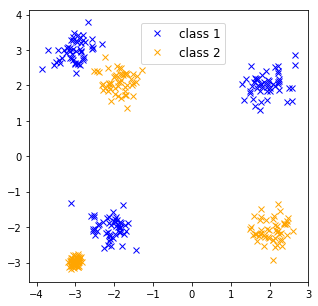

In [10]:
plt.figure(figsize=(5, 5))

x1 = np.random.multivariate_normal([2,2], [[0.1,0],[0,0.1]], 50)
x2 = np.random.multivariate_normal([-2,-2], [[0.1,0],[0,0.1]], 50)
x3 = np.random.multivariate_normal([-3,3], [[0.1,0.1],[0,0.1]], 50)
X1 = np.concatenate((x1,x2,x3), axis=0)

y1 = np.random.multivariate_normal([-2,2], [[0.1,0],[0,0.1]], 50)
y2 = np.random.multivariate_normal([2,-2], [[0.1,0],[0,0.1]], 50)
y3 = np.random.multivariate_normal([-3,-3], [[0.01,0],[0,0.01]], 50)
X2 = np.concatenate((y1,y2,y3), axis=0)

plt.plot(X1[:,0],X1[:,1], 'x', color='blue', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', color='orange', label='class 2')


plt.legend(loc=(0.4, 0.8), fontsize=12)

**Question:** What do you expect the decision boudaries to look like? 

__Answer__

__Question:__ Fill-in the following code to train a decision tree on this toy data and visualize it. 

Change the **splitter** to **random**, meaning that the algorithm will consider the feature along which to split _randomly_, rather than picking the optimal one, and then select the best among several _random_ splitting point. Run the algorithm several times. What do you observer?

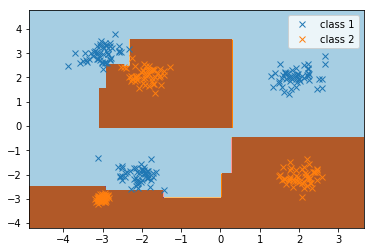

In [32]:
# Training data
X_demo = np.concatenate((X1, X2), axis=0)
y_demo = np.concatenate((np.zeros(X1.shape[0]), np.ones(X2.shape[0])))

# Train a DecisionTreeClassifier on the training data
clf = tree.DecisionTreeClassifier(splitter="random").fit(X_demo, y_demo)

# Create a mesh, i.e., a fine grid of values between the minimum and maximum
# values of x1 and x2 in the training data
plot_step = 0.02
x_min, x_max = X_demo[:, 0].min() - 1, X_demo[:, 0].max() + 1
y_min, y_max = X_demo[:, 1].min() - 1, X_demo[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

# Label each point of the mesh with the trained DecisionTreeClassifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contours corresponding to these labels 
# (i.e. the decision boundary of the DecisionTreeClassifier)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

# Plot the training data 
plt.plot(X1[:,0], X1[:,1], 'x', label='class 1')
plt.plot(X2[:,0], X2[:,1], 'x', label='class 2')
plt.legend()

The features are always randomly permuted at each split. To have a determinist behavior, we have to fix the value of `random_state` parameter.

## 2. Wisconsin Prognostic Breast Cancer dataset

The data are available at https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data

### Data description

* The dataset contains 569 samples of **malign** and **benign** tumor cells
* It has 35 columns, where the first one stores the **unique ID** number of the sample, the second one the diagnosis (M=malignant, B=benign), 3--32 ten real-valued features are computed for each cell nucleus

    * radius (mean of distances from center to points on the perimeter)
    * texture (standard deviation of gray-scale values)
    * perimeter
    * area
    * smoothness (local variation in radius lengths)
    * compactness ($\frac{perimeter^2}{area} - 1.0$)
    * concavity (severity of concave portions of the contour)
    * concave points (number of concave portions of the contour)
    * symmetry
    * fractal dimension (coastline approximation - 1); 5 here 3--32 are divided into three parts first is Mean (3-13), Stranded Error(13-23) and Worst(23-32) and each contain 10 parameter (radius, texture,area, perimeter, smoothness,compactness,concavity,concave points,symmetry and fractal dimension).
    
The goal is to classify whether the breast cancer is **benign** or **malignant**. 

### Loading the data





In [33]:
from sklearn.datasets import load_breast_cancer
cancer_ds = load_breast_cancer()

In [41]:
X = cancer_ds.data
y = cancer_ds.target

In [42]:
## make folds
from sklearn import model_selection

skf = model_selection.StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
folds = [(tr,te) for (tr,te) in skf.split(X, y)]

### Cross-validation procedures

In [45]:
def cross_validate_clf(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        pos_idx = list(classifier.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

In [46]:
def cross_validate_clf_optimize(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns the predictions.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - predict_proba(X) to apply the trained classifier to the data X and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        classifier.fit(design_matrix[tr,:], labels[tr])
        print(classifier.best_params_)
        pos_idx = list(classifier.best_estimator_.classes_).index(1)
        pred[te] = (classifier.predict_proba(design_matrix[te,:]))[:, pos_idx]
    return pred

## 1.2 Breast cancer tumor classification data

Let us now go back to our tumor classification problem.

**Question:** Cross-validate 5 different decision trees (with default parameters) and print out their accuracy. 
Why do you get different values? _Hint:_ _Check the documentation_ (?tree.DecisionTreeClassifier)

In [56]:
from sklearn import metrics

ypred_dt = [] # will hold the 5 arrays of predictions (1 per tree)

for tree_index in range(5):
    # Initialize a DecisionTreeClassifier
    clf = tree.DecisionTreeClassifier() 
    
    # Cross-validate this DecisionTreeClassifier on breast cancer data
    pred_proba = cross_validate_clf(X, y, clf, folds)
    
    # Append the prediction to ypred_dt 
    ypred_dt.append(pred_proba)
    
    # Print the accuracy of DecisionTreeClassifier
    print("%.3f" % metrics.accuracy_score(y, np.where(pred_proba > 0.5, 1, 0)))

0.914
0.926
0.917
0.919
0.916


**Question:** Compute the mean and standard deviation of the area under the ROC curve of these 5 trees. Plot the ROC curves of these 5 trees.

Use the [metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module of scikit-learn.

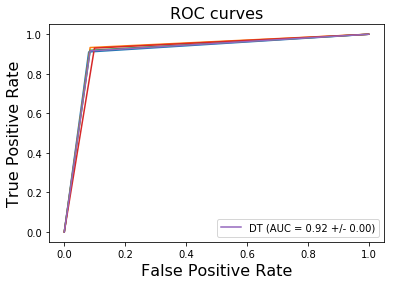

In [57]:
fpr_dt = [] 
tpr_dt = [] 
auc_dt = []

for tree_index in range(5):
    # Compute the ROC curve of the current tree
    fpr_dt_tmp, tpr_dt_tmp, thresholds =  metrics.roc_curve(y, ypred_dt[tree_index], pos_label=1)
    # Compute the area under the ROC curve of the current tree
    auc_dt_tmp = metrics.auc(fpr_dt_tmp, tpr_dt_tmp)
    fpr_dt.append(fpr_dt_tmp)
    tpr_dt.append(tpr_dt_tmp)
    auc_dt.append(auc_dt_tmp)

# Plot the first 4 ROC curves
for tree_index in range(4):
    plt.plot(fpr_dt[tree_index], tpr_dt[tree_index], '-')
            
# Plot the last ROC curve, with a label that gives the mean/std AUC
plt.plot(fpr_dt[-1], tpr_dt[-1], '-', 
         label='DT (AUC = %0.2f +/- %0.2f)' % (np.mean(auc_dt), np.std(auc_dt)))

# Plot the ROC curve
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves', fontsize=16)
plt.legend(loc="lower right")

## 1.3 Visualizing the decision trees built for the breast cancer classification

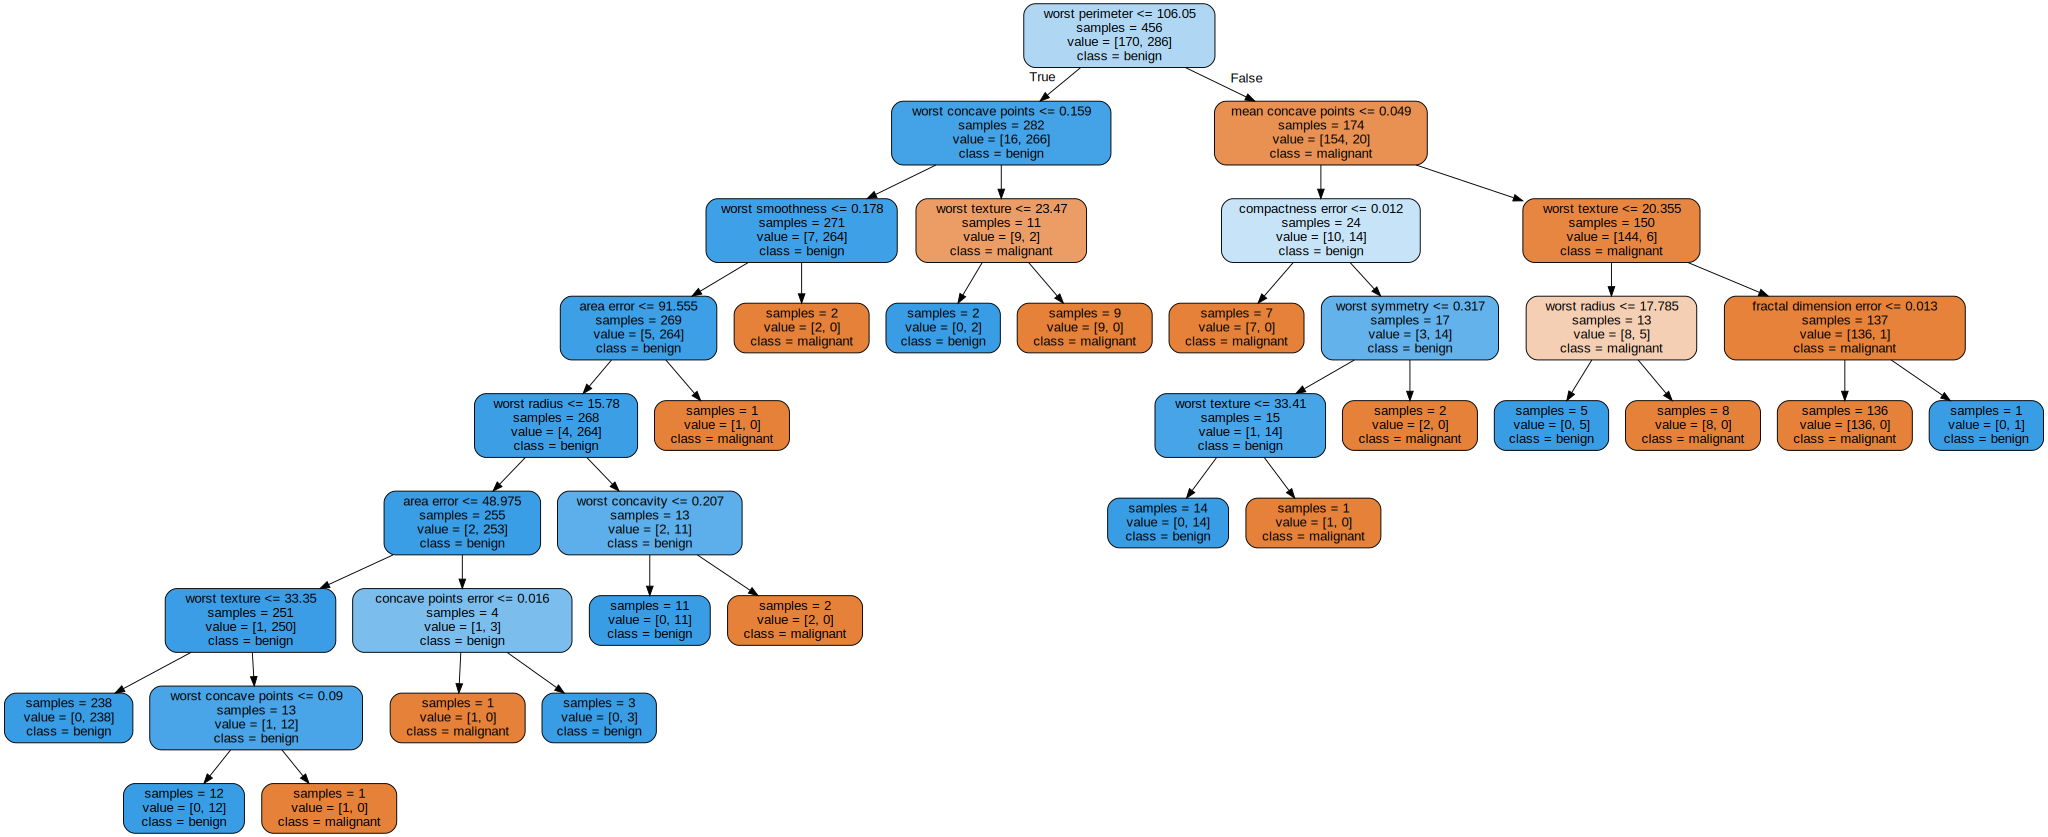

In [61]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
import graphviz

dot_model = export_graphviz(clf, class_names = ['malignant', 'benign'], 
                            feature_names = cancer_ds.feature_names, 
                            impurity = False,
                            filled = True,
                            rounded = True)

graph = graphviz.Source(dot_model)

SVG(graph.pipe(format='svg'))

In [59]:
! conda install -y -c conda-forge graphviz xorg-libxrender xorg-libxpm
! pip install graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - graphviz
    - xorg-libxpm
    - xorg-libxrender


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.12               |           py37_2         2.1 MB  conda-forge
    xorg-libxpm-3.5.12         |    h14c3975_1002          64 KB  conda-forge
    xorg-xextproto-7.3.0       |    h14c3975_1002          27 KB  conda-forge
    xorg-libxrender-0.9.10     |    h516909a_1002          31 KB  conda-forge
    xorg-libxext-1.3.4         |       h516909a_0          51 KB  conda-forge
    xorg-libx11-1.6.7          |    h14c3975_1000         940 KB  conda-forge
    xorg-libxt-1.1.5           |    h14

In [63]:
def plot_feature_importances(model, n_features, feature_names):
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.ylabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

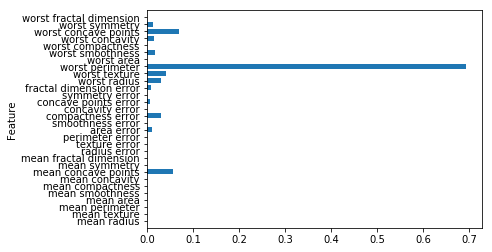

In [64]:
plot_feature_importances(clf, cancer_ds.data.shape[1], cancer_ds.feature_names)

In [117]:
tennis = pd.read_csv('playtennis.csv')
tennis.head()

,day,outlook,temperature,humidity,wind,playtennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,Hight,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [118]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

for c in tennis.columns:
    tennis[c + '_'] = lb.fit_transform(tennis[c])

tennis.head()

,day,outlook,temperature,humidity,wind,playtennis,day_,outlook_,temperature_,humidity_,wind_,playtennis_
0,D1,Sunny,Hot,High,Weak,No,0,2,1,0,1,0
1,D2,Sunny,Hot,Hight,Strong,No,6,2,1,1,0,0
2,D3,Overcast,Hot,High,Weak,Yes,7,0,1,0,1,1
3,D4,Rain,Mild,High,Weak,Yes,8,1,2,0,1,1
4,D5,Rain,Cool,Normal,Weak,Yes,9,1,0,2,1,1


In [151]:
X = tennis.iloc[:,7:11] 
Y = tennis.iloc[:,11]

tennis_tree = DecisionTreeClassifier(criterion='entropy')
tennis_tree.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

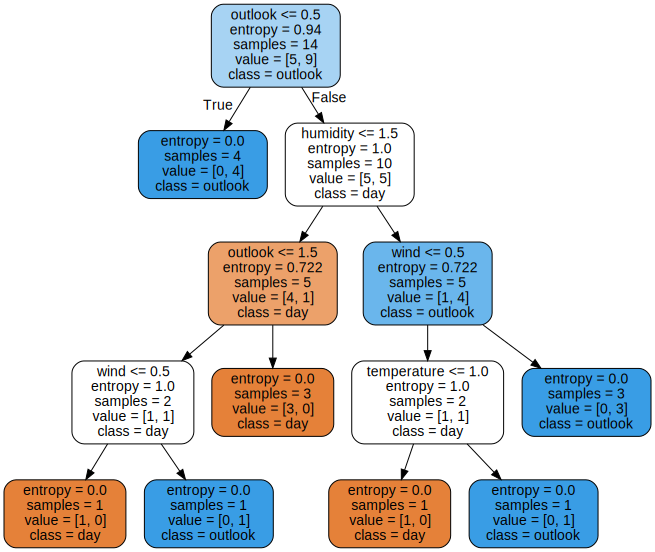

In [165]:
dot_model = export_graphviz(tennis_tree, 
                            class_names = tennis.columns[0:5], 
                            feature_names = tennis.columns[1:5], 
                            impurity = True,
                            filled = True,
                            rounded = True)

graph = graphviz.Source(dot_model)
SVG(graph.pipe(format='svg'))

In [161]:
?export_graphviz

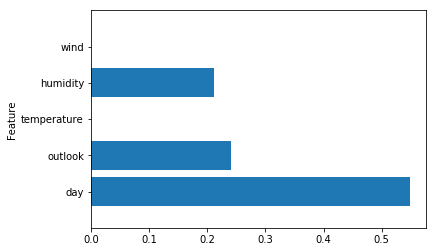

In [148]:
plot_feature_importances(tennis_tree, 5, tennis.columns[0:5])

In [150]:
tennis.iloc[:,7:11] 

,outlook_,temperature_,humidity_,wind_
0,2,1,0,1
1,2,1,1,0
2,0,1,0,1
3,1,2,0,1
4,1,0,2,1
5,1,0,2,0
6,0,0,2,0
7,2,2,0,1
8,2,0,2,1
9,1,2,2,1
